In [1]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


In [2]:
files_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/knowledge-distillation/autoencoders/output/'
train_loss_file = files_dir + 'l1_ae_train_loss.h5'
signal_loss_file = files_dir + 'l1_ae_signal_loss.h5'

In [3]:
signal_sample_name = 'A to 4 leptons'
with h5py.File(train_loss_file,'r') as open_file :
    train_loss = np.array(open_file['teacher_loss'])
    train_data = np.array(open_file['data'])
with h5py.File(signal_loss_file,'r') as open_file :
    signal_loss = np.array(open_file['teacher_loss_%s'%signal_sample_name])
    signal_data = np.array(open_file['bsm_data_%s'%signal_sample_name])


Text(0.5, 1.0, 'Training Sample')

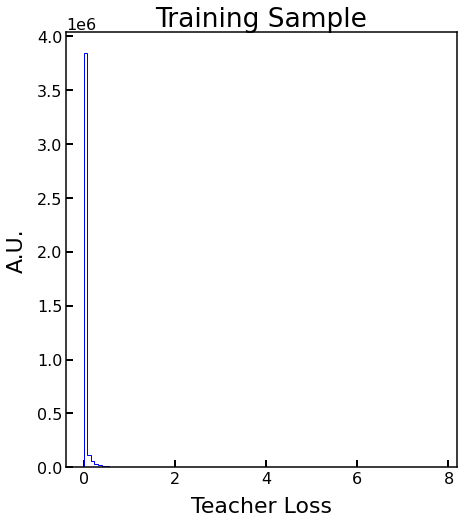

In [66]:
#values, bins, patches = plt.hist(signal_loss,bins=100,histtype='step',color='r')
values, bins, patches = plt.hist(train_loss,bins=100,histtype='step',color='b')
bincenters = 0.5*(bins[1:]+bins[:-1])
#plt.semilogy()
plt.xlabel('Teacher Loss')
plt.ylabel('A.U.')
plt.title('Training Sample')

In [5]:
def fit_function(x, a, b):
    return a * np.exp(-b * x)

In [6]:
threshold = 1.2
fit_range_mask = bincenters>threshold
popt, pcov = curve_fit(fit_function, xdata=bincenters[fit_range_mask], ydata=values[fit_range_mask])

ratio_function = fit_function(bincenters, *popt)/values
ratio_function[np.where(ratio_function>1.)[0][0]:]=1.

def selective_sampling(sample,bincenters,ratio_function):
    random_array = np.random.random(len(sample))
    indecies = np.searchsorted(bincenters, sample,side='left')-1 #better to do without -1, and shift max by 1 in the next line
    indecies = np.where(indecies==-1,0,indecies)
    indecies_to_keep = np.where(random_array<ratio_function[indecies])
    return indecies_to_keep

indecies_to_keep = selective_sampling(train_loss,bincenters,ratio_function)
print(len(train_loss[indecies_to_keep]))

indecies_to_keep_signal = np.random.choice(len(signal_loss), int(len(signal_loss)/4.))

25806


/tmp/nchernya/ipykernel_29634/3491146971.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ratio_function = fit_function(bincenters, *popt)/values


Text(0.5, 0, 'Teacher Loss')

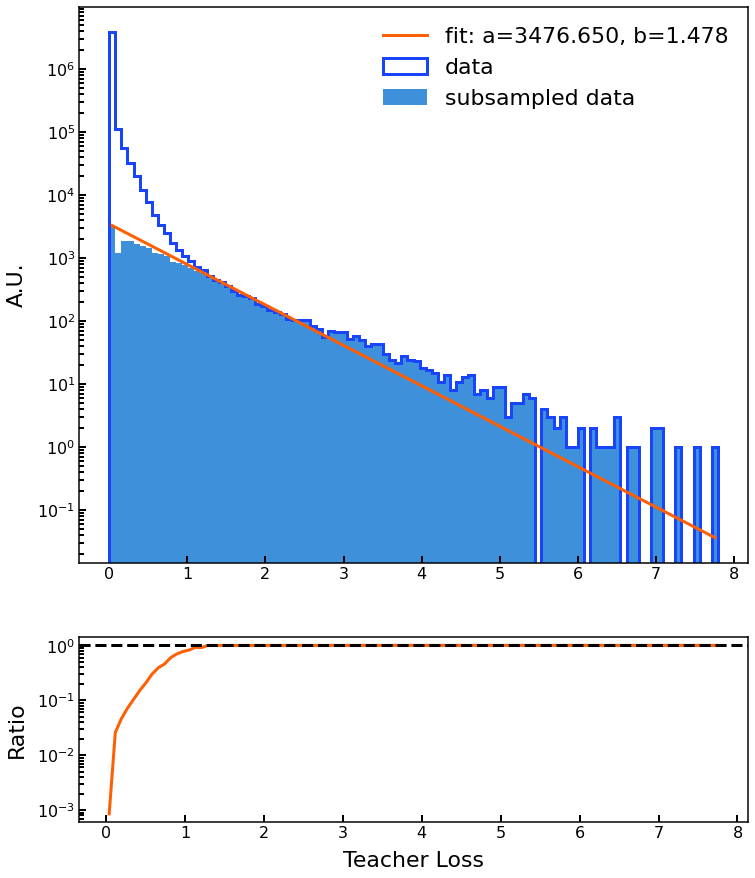

In [67]:
matplotlib.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(2,figsize=(12,15), gridspec_kw={'height_ratios': [3, 1]})
_ = axs[0].hist(train_loss,bins=100,histtype='step',linewidth=3,color='#1845fb',label='data')
#_ = axs[0].hist(signal_loss[indecies_to_keep_signal],bins=100,histtype='step',color='#ef5675',linewidth=3,label=signal_sample_name)
axs[0].hist(train_loss[indecies_to_keep],bins=100,color='#3f90da',label='subsampled data')
axs[0].plot(bincenters, fit_function(bincenters, *popt), '#ff5e02',linewidth=3,
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
axs[0].semilogy()
axs[0].set_ylabel('A.U.')
axs[0].legend()
_ = axs[1].plot(bincenters,ratio_function,'#ff5e02',linewidth=3)
axs[1].axhline(1., color='black',linestyle='--',linewidth=3)
axs[1].semilogy()
axs[1].set_ylabel('Ratio')
axs[1].set_xlabel('Teacher Loss')


In [35]:
mask_signal_for_valid = np.ones(len(signal_loss), dtype=bool)
mask_signal_for_valid[indecies_to_keep_signal] = False

save_output = False
if save_output:
    ouput_selective_sampling = files_dir+'l1_ae_train_loss_selective_sampling_bg_a4l.h5'
    with h5py.File(ouput_selective_sampling, 'w') as h5f:
        h5f.create_dataset('teacher_loss', data=np.concatenate((train_loss[indecies_to_keep],signal_loss[indecies_to_keep_signal]), axis=0))
        h5f.create_dataset('data', data=np.concatenate((train_data[indecies_to_keep],signal_data[indecies_to_keep_signal]), axis=0))
        
    output_validation_signal = files_dir+'l1_ae_signal_loss_validation.h5'
    with h5py.File(output_validation_signal,'r+') as h5f:
        del h5f['teacher_loss_%s'%signal_sample_name] 
        del h5f['bsm_data_%s'%signal_sample_name] 
        h5f.create_dataset('teacher_loss_%s'%signal_sample_name,data=signal_loss[mask_signal_for_valid])    
        h5f.create_dataset('bsm_data_%s'%signal_sample_name,data=signal_data[mask_signal_for_valid])    



/tmp/nchernya/ipykernel_29634/4050296447.py:15: RuntimeWarning: divide by zero encountered in true_divide
  _ = axs[1].plot(bincenters,values_combi/values_bg,'r',linewidth=3)
/tmp/nchernya/ipykernel_29634/4050296447.py:15: RuntimeWarning: invalid value encountered in true_divide
  _ = axs[1].plot(bincenters,values_combi/values_bg,'r',linewidth=3)


Text(0.5, 0, 'Teacher Loss')

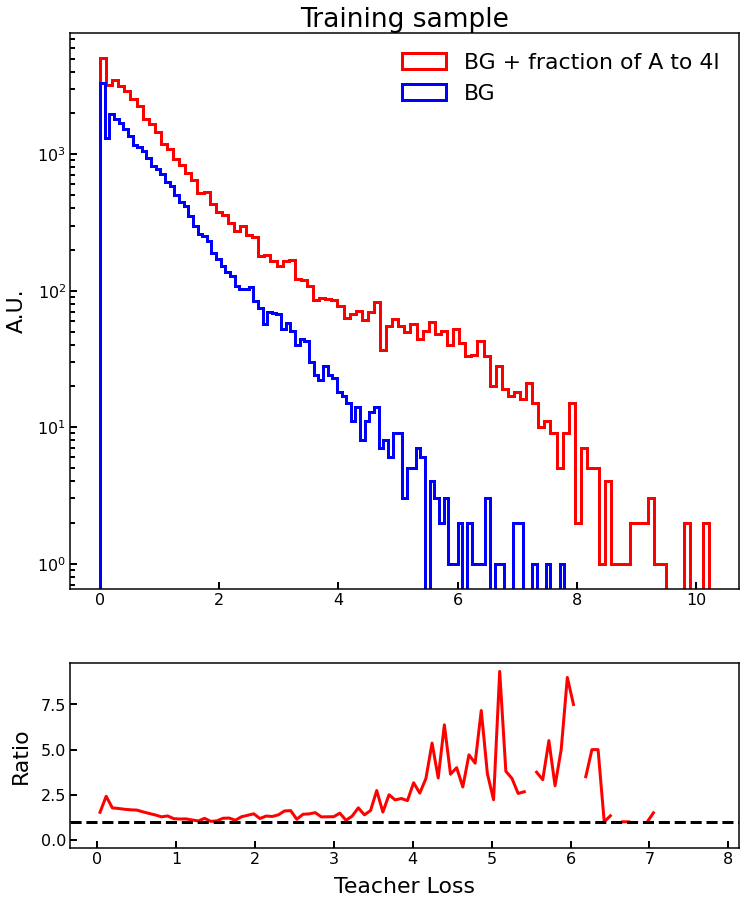

In [53]:
with h5py.File(ouput_selective_sampling,'r') as open_file :
    train_loss_combi = np.array(open_file['teacher_loss'])
with h5py.File(files_dir+'l1_ae_train_loss_selective_sampling.h5','r') as open_file :
    train_loss_selective = np.array(open_file['teacher_loss'])
    
fig, axs = plt.subplots(2,figsize=(12,15), gridspec_kw={'height_ratios': [3, 1]})
values_combi, bins, patches = axs[0].hist(train_loss_combi,bins=100,histtype='step',color='r',linewidth=3,label='BG + fraction of A to 4l')
values_bg, bins, patches = axs[0].hist(train_loss_selective,bins=100,histtype='step',color='b',linewidth=3,label='BG')
bincenters = 0.5*(bins[1:]+bins[:-1])
axs[0].semilogy()
axs[0].legend()
axs[0].set_title('Training sample')
axs[0].set_ylabel('A.U.')

_ = axs[1].plot(bincenters,values_combi/values_bg,'r',linewidth=3)
axs[1].axhline(1., color='black',linestyle='--',linewidth=3)
axs[1].set_ylabel('Ratio')
axs[1].set_xlabel('Teacher Loss')